# Clustering Analysis and Portfolio Optimization

## Section 1: Library Imports and Ticker Definition

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
from scipy.stats import dirichlet
import joblib

### Ticker Definition:
A list of `TICKERS` is defined, representing stocks from various industries:
- Technology, Health, Energy, Finance, Consumer, etc.
- These tickers are used to download historical price data.

In [2]:
TICKERS = [
    # Technology
    'AAPL', 'MSFT', 'GOOGL', 'NVDA','AMZN', 'META', 'INTC', 'AMD', 'CSCO',

    # Healthcare
    'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV', 'BMY', 'GILD', 'REGN', 'VRTX', 'LLY',

    # Energy
    'XOM', 'CVX', 'SLB', 'BP', 'COP', 'OXY', 'EOG', 'KMI', 'PSX', 'HAL',

    # Financials
    'JPM', 'GS', 'BRK-B', 'C', 'BAC', 'WFC', 'MS', 'AXP', 'BLK', 'SCHW',

    # Consumer Staples
    'KO', 'PEP', 'PG', 'WMT', 'MO', 'CL', 'KMB', 'EL', 'STZ', 'COST',

    # Consumer Discretionary
    'DIS', 'TSLA', 'NFLX', 'HD', 'NKE', 'SBUX', 'MCD', 'TGT', 'LOW',

    # Industrials
    'BA', 'CAT', 'UPS', 'LMT', 'MMM', 'GE', 'HON', 'DE', 'UNP', 'CSX',

    # Telecommunications
    'VZ', 'T', 'TMUS', 'CHT', 'CMCSA', 'EA', 'NOK', 'ERIC', 'CCI', 'SBAC',

    # ETFs
    'SPY', 'QQQ', 'VTI', 'EWW', 'IEMG', 'EFA', 'VWO', 'IXC', 'XLE', 'XLF',
]

## Section 2: Data Download and Return Preparation

### Data Download:
- Using `yfinance`, closing prices of the defined tickers are downloaded from 2014 to 2024.
- The variable `data` contains the DataFrame with the closing prices.

In [3]:
data = yf.download(TICKERS, start="2014-01-01", end="2024-12-31")['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  88 of 88 completed


### Return Calculation:
- Logarithmic returns are calculated using `np.log(data / data.shift(1))`.
- The `NaN` values generated by the return calculation are removed using `.dropna()`.

In [4]:
# Calculate Logarithmic Returns
returns = np.log(data / data.shift(1)).dropna()

## Section 3: Correlation Analysis

### Correlation Matrix:
- The correlation matrix between the returns of the stocks is calculated with `returns.corr()`.
- This matrix shows how the stocks move together.

In [5]:
# Correlation Matrix
correlation_matrix = returns.corr()

### Correlation Visualization:
- Using `seaborn.heatmap`, a heatmap visualization of the correlation matrix is generated.
- The figure size is adjusted for better visualization, and cell values are removed (`annot=False`).

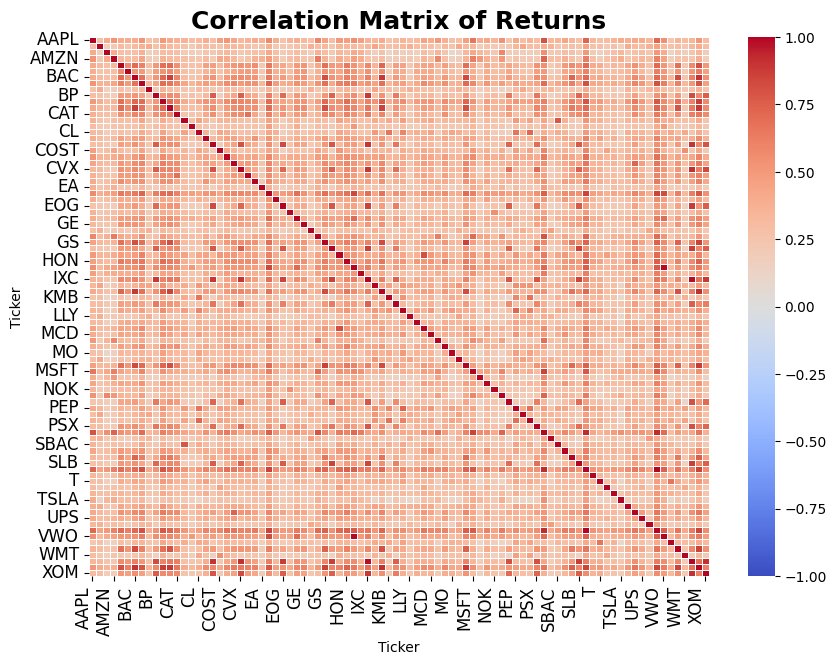

In [6]:
# Adjust figure size based on the number of assets
plt.figure(figsize=(10,7))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',  # Remove values
            vmin=-1, vmax=1,  # Limit colorbar range
            linewidths=0.5,  # Cell borders
            linecolor='white')  # Change cell border color

# Improve presentation
plt.title("Correlation Matrix of Returns", fontsize=18, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12)  # Increase column label size
plt.yticks(rotation=0, fontsize=12)  # Increase row label size

plt.show()

## Section 4: Hierarchical Clustering

### Data Normalization:
- The return data is normalized with `StandardScaler` to ensure all stocks have a similar weight in the clustering, eliminating the original scale of the data.

In [7]:
# Normalize the data for Hierarchical Clustering
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns.T)

### Distance Matrix:
- The correlation matrix is converted into a distance matrix using `1 - correlation_matrix`.
- This matrix is then transformed into a condensed form using `squareform`.

In [8]:
# Convert the correlation matrix to a distance matrix (1 - correlation)
distance_matrix = 1 - correlation_matrix
# Convert the distance matrix to condensed form
condensed_distance_matrix = squareform(distance_matrix)

### Dendrogram Generation:
- Using `scipy.cluster.hierarchy.linkage`, the structure of the clusters (linkage) is computed using the 'ward' method.
- The dendrogram is a visual representation of how the stocks group together as their distance increases.
- The optimal distance threshold (`optimal_threshold`) is found by observing the difference between consecutive distances in the linkage.

In [9]:
# Generate the linkage with the best linkage method
Z = linkage(condensed_distance_matrix, method='ward')  # You can change the method here

# Calculate the optimal number of clusters using the Dendrogram (using the optimal threshold)
distances = Z[:, 2]  # Extract the distances
distance_diff = np.diff(distances)  # Difference between consecutive distances
threshold_index = np.argmax(distance_diff)  # Largest gap in the distance
optimal_threshold = distances[threshold_index]  # Optimal threshold

# Use fcluster to obtain clusters based on the threshold
clusters = fcluster(Z, optimal_threshold, criterion='distance') 

### Dendrogram Visualization:
- The dendrogram is drawn, and the optimal threshold is marked using `plt.axhline`. This threshold defines the number of clusters in the analysis.

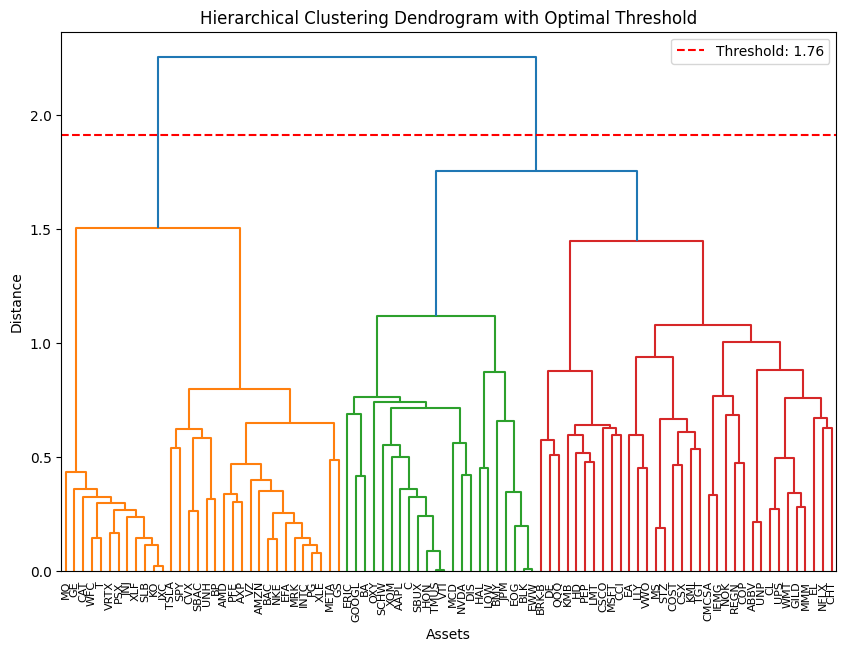

Optimal number of clusters (Dendrogram): 2
Optimal Threshold: 1.76


In [10]:
# Get the optimal number of clusters from the dendrogram
optimal_k_dendrogram = len(set(clusters))

# Plot the Dendrogram with the optimal threshold
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=TICKERS, leaf_rotation=90, leaf_font_size=8)
separation = optimal_threshold * 1.09
plt.axhline(y=separation, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.2f}')
plt.title("Hierarchical Clustering Dendrogram with Optimal Threshold")
plt.xlabel("Assets")
plt.ylabel("Distance")
plt.legend()
plt.show()

# Print the optimal number of clusters from the Dendrogram
print(f"Optimal number of clusters (Dendrogram): {optimal_k_dendrogram}")
print(f"Optimal Threshold: {optimal_threshold:.2f}")

## Section 5: Clustering Quality Evaluation

### Silhouette Score Calculation:
- A function is defined to evaluate clustering quality using the Silhouette Index, which measures how well points fit within their clusters.
- Different values of `k` (number of clusters), linkage methods, and distance metrics (Euclidean, Manhattan, etc.) are evaluated, and the best model with the highest Silhouette Score is selected.

In [ ]:
def evaluate_silhouette(k, linkage_method, metric, data):
    try:
        # Perform clustering and calculate the Silhouette Score
        clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        labels = clustering.fit_predict(data)
        return silhouette_score(data, labels, metric=metric)
    except Exception as e:
        print(f"Error evaluating k={k} with {linkage_method} and metric {metric}: {e}")
        return -1  # Return an invalid value if there's an error

# Initialize evaluation variables
best_score = -1
optimal_k_silhouette = 0

# Dictionary to store results only for the best linkage method and metric
silhouette_scores = {}

# The range of k goes from a minimum value to a dynamic maximum value
min_k = 3  # Minimum value of k, you can adjust it as needed
max_k = len(TICKERS)  # Maximum value of k will be the total number of assets
metrics = ['euclidean', 'manhattan', 'cosine']
methods = ['ward', 'complete', 'average', 'single']

# Evaluation for different values of k, linkage method, and metrics
for k in range(min_k, max_k):  # We use the dynamic range
    for linkage_method in methods:
        for metric in metrics:
            score = evaluate_silhouette(k, linkage_method, metric, scaled_returns)
            if score != -1:  # Only store valid results
                if score > best_score:
                    best_score = score
                    best_linkage = linkage_method
                    best_metric = metric
                    optimal_k_silhouette = k  # Update the optimal k when a better score is found

### Silhouette Score Results Visualization:
- The results of the Silhouette Score are plotted to determine the optimal number of clusters (`optimal_silhouette_k`) and the best clustering method.

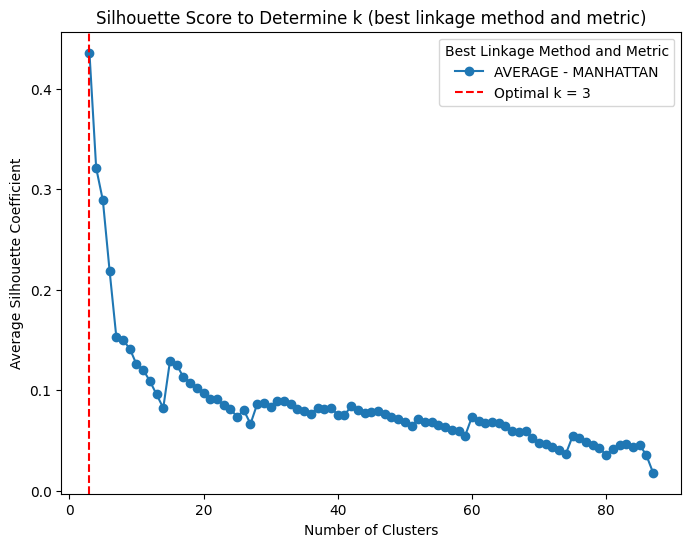

Best linkage method: AVERAGE with metric MANHATTAN and 3 clusters and Silhouette Score: 0.44


In [12]:
# Plot the Silhouette Score vs. Number of Clusters for the best method and metric
# Only take the values corresponding to the best method and metric
plt.figure(figsize=(8, 6))

# Recalculate the Silhouette Score for the values of k with the best method and metric
best_method_scores = []
for k in range(min_k, max_k):
    score = evaluate_silhouette(k, best_linkage, best_metric, scaled_returns)
    if score != -1:
        best_method_scores.append((k, score))

# Convert to DataFrame for easier visualization
df_scores = pd.DataFrame(best_method_scores, columns=["k", "score"])

# Plot the result
plt.plot(df_scores['k'], df_scores['score'], marker='o', label=f'{best_linkage.upper()} - {best_metric.upper()}')

# 3. Add a vertical line for the optimal k
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')

# Titles and labels
plt.title("Silhouette Score to Determine k (best linkage method and metric)")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Coefficient")
plt.legend(title="Best Linkage Method and Metric")
plt.show()

# Print the best result based on the Silhouette Score
print(f"Best linkage method: {best_linkage.upper()} with metric {best_metric.upper()} and {optimal_k_silhouette} clusters and Silhouette Score: {best_score:.2f}")

## Section 6: Application of Optimal Clustering

### Clustering Application:
- Using the optimal number of clusters (`optimal_silhouette_k`) and the best linkage method (`best_linkage_method`), agglomerative clustering is performed using `AgglomerativeClustering`.
- The clustering results are saved using `joblib.dump` to store them in a `.pkl` file.

In [13]:
# Apply Hierarchical Clustering with the optimal number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_k_silhouette, linkage=best_linkage)
labels = agglomerative_clustering.fit_predict(scaled_returns)

joblib.dump(agglomerative_clustering, '../models/agglomerative_clustering.pkl')

print("Clustering model saved successfully.")

Clustering model saved successfully.


### Clustering Visualization with PCA:
- The dimensionality of the data is reduced to 2 dimensions using `PCA`, and the clusters are visualized with `sns.scatterplot`.

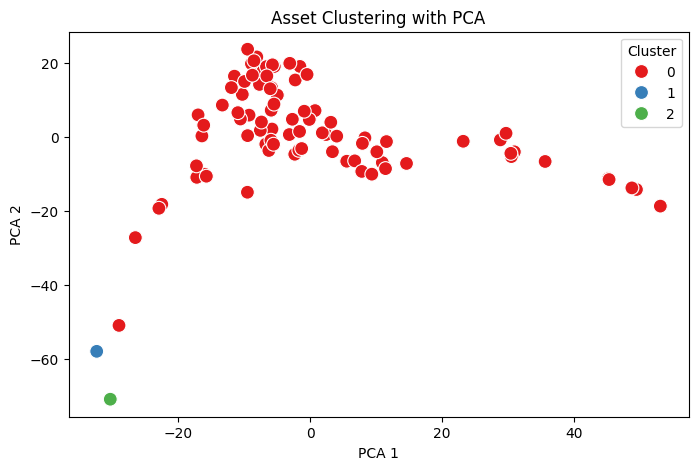

In [14]:
# Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_returns)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set1', s=100)
plt.title("Asset Clustering with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

## Section 7: Selection of Representative Assets

### Representative Asset Selection:
- For each cluster, the asset with the best Sharpe ratio is selected. The Sharpe ratio is calculated as:
  \[
  \text{Sharpe} = \frac{(\text{average return} - \text{risk-free rate})}{\text{volatility}}
  \]
- The selected assets are those that maximize the Sharpe ratio within their respective cluster.

In [15]:
# Select a Representative Asset from Each Cluster based on Average Return
df_cluster = pd.DataFrame({'Ticker': TICKERS, 'Cluster': labels})

risk_free_rate = 0.03 / 252  # Convert to daily returns 

def select_optimal_asset(assets_in_cluster):
    valid_assets = set(assets_in_cluster) & set(returns.columns)  # Intersection between both sets
    if not valid_assets:
        return None

    # Convert the intersection back to a list
    valid_assets = list(valid_assets)
    
    average_returns = returns[valid_assets].mean()
    volatilities = returns[valid_assets].std() + 1e-8  # Add a small value to avoid division by zero
    sharpe_ratios = (average_returns - risk_free_rate) / volatilities
    
    return sharpe_ratios.idxmax()  # Return the ticker with the highest Sharpe ratio

# Select the optimal assets from each cluster
selected_assets = df_cluster.groupby('Cluster')['Ticker'].apply(select_optimal_asset).dropna().values

# Show selected assets for portfolio optimization
print("Selected Assets for Portfolio Optimization:", selected_assets.tolist())

Selected Assets for Portfolio Optimization: ['NVDA', 'ERIC', 'GOOGL']


## Section 8: Portfolio Optimization

### Portfolio Optimization:
- Portfolio optimization is performed using the Markowitz model with Ridge regularization.
- The optimization function (`regularized_sharpe_ratio`) maximizes the Sharpe ratio adjusted for the risk-free rate, adding a regularization term to avoid overfitting.
- Portfolio weights are optimized ensuring that the sum of the weights equals 1 and that the weights are within reasonable bounds.

In [ ]:
# Get returns and covariance matrix of selected assets
selected_returns = returns[selected_assets]
average_returns = selected_returns.mean()  
cov_matrix = selected_returns.cov()    

# 3. Optimization function to find the best asset combination
def regularized_sharpe_ratio(weights, average_returns, cov_matrix, lambda_ridge=0.05):
    return_expected_return = np.sum(weights * average_returns)  # Expected return of the portfolio
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility
    regularization = lambda_ridge * np.sum(weights**2)  # Regularization term (Ridge)
    return -((return_expected_return - risk_free_rate) / portfolio_volatility) + regularization  # Minimize regularized Sharpe Ratio

# Efficient Frontier Optimization
# Required parameters
num_assets = len(selected_assets)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Constraint that weights sum to 1
volatilities = np.sqrt(np.diag(cov_matrix))  # Volatility of each asset
bounds = tuple((0.01, min(0.50, 1 / vol)) for vol in volatilities)  # Limit weights between 0.01 and 0.50 or 1/volatility

# Initial random weights
initial_weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  

# Perform optimization
optimization_result = minimize(regularized_sharpe_ratio, initial_weights, args=(average_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimization_result.x  # Optimal weights found


### Calculation of Portfolio Return and Risk

The expected portfolio return is calculated as the weighted sum of the average returns of the assets:

In [17]:
# Calculate expected return and risk of the optimal portfolio
portfolio_return = np.sum(optimal_weights * average_returns)  # Expected return of the portfolio
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Portfolio risk
optimal_sharpe = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)  # Sharpe ratio of the optimal portfolio

# Generate random portfolios for the efficient frontier
num_portfolios = 10000  # Number of portfolios to generate
results = np.zeros((3, num_portfolios))  # Return, Risk, Sharpe Ratio
weights_record = np.zeros((num_portfolios, num_assets))  # Record of weights for each portfolio

for portfolio_idx in range(num_portfolios):
    weights = np.random.uniform(0.01, 0.50, num_assets)  # Weights between 0.01 and 0.50 for each asset
    weights /= np.sum(weights)  # Normalize to sum to 1 (fully invested portfolio)
    
    # Record the generated weights for this portfolio
    weights_record[portfolio_idx, :] = weights
    # Calculate expected return of the portfolio
    return_portfolio = np.dot(weights, average_returns)  # Use np.dot for efficient multiplication (weighted sum)
    # Calculate portfolio volatility (risk) using the covariance matrix
    volatility_portfolio = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Calculate volatility
    # Calculate Sharpe ratio for this portfolio (adjusted for risk-free rate)
    sharpe = (return_portfolio - risk_free_rate) / volatility_portfolio if volatility_portfolio != 0 else 0  # Adjusted Sharpe ratio
    # Record portfolio results: return, risk, Sharpe
    results[:, portfolio_idx] = [return_portfolio, volatility_portfolio, sharpe]

### Visualization of the Efficient Frontier:
- An efficient frontier visualization is generated, showing the relationship between return and risk (volatility) of the generated portfolios.
- The optimal portfolio with the highest Sharpe ratio is highlighted.

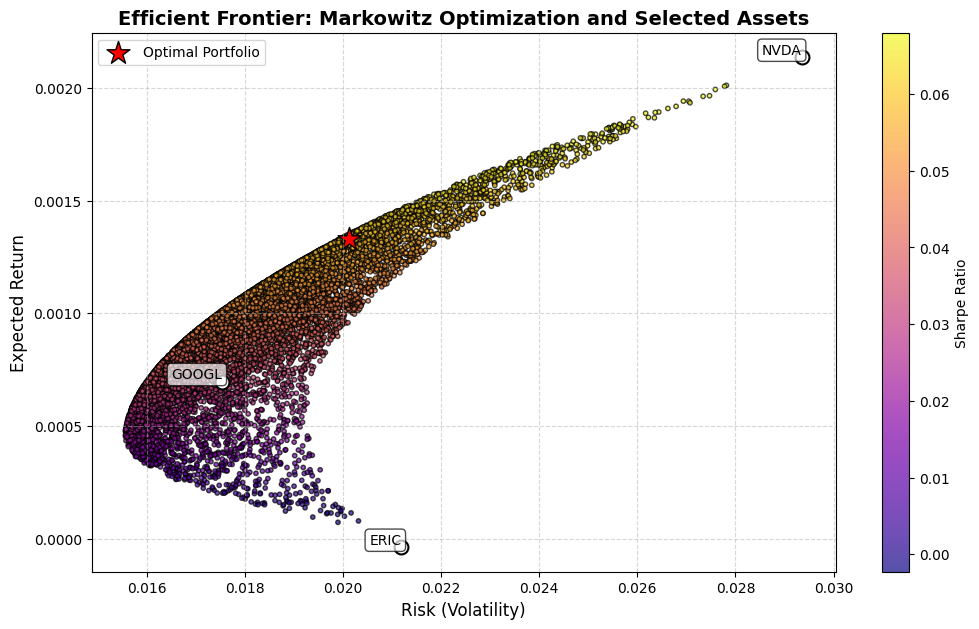

In [18]:
# Efficient Frontier Visualization
plt.figure(figsize=(12, 7))

# Plot the efficient frontier with more visible colors
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.7, edgecolors='k', s=10)
plt.colorbar(scatter, label='Sharpe Ratio')

# Highlight the optimal portfolio with a striking color
plt.scatter(portfolio_volatility, portfolio_return, color='red', edgecolors='black', marker='*', s=300, label='Optimal Portfolio')

# Plot selected assets with labels and better visibility
asset_volatilities = np.sqrt(np.diag(cov_matrix))  # Volatilities of selected assets
for asset, vol, ret in zip(selected_assets, asset_volatilities, average_returns):
    plt.scatter(vol, ret, color='white', edgecolors='black', marker='o', s=100, linewidth=1.5)  # Selected assets
    plt.text(vol, ret, asset, fontsize=10, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

# Improve presentation
plt.xlabel('Risk (Volatility)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Efficient Frontier: Markowitz Optimization and Selected Assets', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Section 9: Final Calculations and Results Visualization

### Final Results:
- The final results are printed: the optimal weights of each asset in the portfolio, the expected return, volatility, and Sharpe ratio.

In [19]:
# Final Results
print("Optimal portfolio weights based on hierarchical clustering and Markowitz optimization:")
for asset, weight in zip(selected_assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")

print(f"Expected Return of the Optimal Portfolio: {portfolio_return:.2%}")
print(f"Volatility of the Optimal Portfolio: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio of the Optimal Portfolio: {optimal_sharpe:.4f}")

Optimal portfolio weights based on hierarchical clustering and Markowitz optimization:
NVDA: 50.00%
ERIC: 12.02%
GOOGL: 37.98%
Expected Return of the Optimal Portfolio: 0.13%
Volatility of the Optimal Portfolio: 2.01%
Sharpe Ratio of the Optimal Portfolio: 0.0601


### Calculation of Portfolio Historical Prices:
- The accumulated portfolio prices over time are calculated using the weighted returns of the selected assets.
- The evolution of the portfolio value over time is visualized.

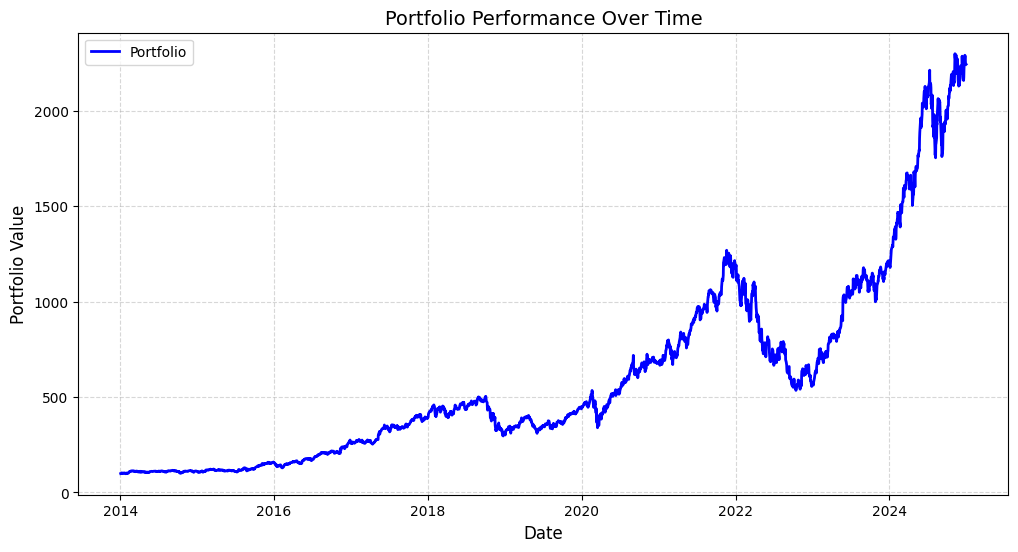

Weighted portfolio return: -0.16%
Accumulated portfolio price in the last period: 2244.74


In [20]:
# Calculate the portfolio returns (already calculated earlier)
portfolio_returns = np.dot(selected_returns, optimal_weights)  # Weighted portfolio returns

# Calculate the accumulated portfolio prices
# Let's assume we start with an initial value of 100 (you can normalize to 1 if you'd prefer)
initial_portfolio_value = 100  # You can adjust this value if needed
historical_portfolio_prices = (1 + portfolio_returns).cumprod() * initial_portfolio_value  # Accumulated price

# Plot the historical prices of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(selected_returns.index, historical_portfolio_prices, label='Portfolio', color='b', linewidth=2)

# Add labels and title
plt.title('Portfolio Performance Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

print(f"Weighted portfolio return: {portfolio_returns[-1] * 100:.2f}%")
print(f"Accumulated portfolio price in the last period: {historical_portfolio_prices[-1]:.2f}")

# Conclusion and Final Results

After performing portfolio analysis and optimization based on hierarchical clustering and the Markowitz model, the following results were obtained:

### 1. Optimal Number of Clusters (Dendrogram): 
   - The optimal number of clusters identified is **2**, based on the dendrogram visualization, suggesting a significant division between the assets.

### 2. Optimal Threshold: 
   - The optimal threshold for determining clusters is **1.76**, marking the cutoff point in the clustering hierarchy.

### 3. Best Linkage Method: Average with Manhattan Metric and 3 Clusters
   - The **Average** linkage method with the **Manhattan** metric was selected, resulting in a **Silhouette Score of 0.44**, indicating a moderate quality of clustering.

---

### 4. Assets Selected for Portfolio Optimization:
The selected assets for portfolio optimization are:
   - **NVDA** (NVIDIA)
   - **ERIC** (Ericsson)
   - **GOOGL** (Google)

---

### 5. Optimal Portfolio Weights:

| Asset  | Weight (%) |
|--------|------------|
| **NVDA** (NVIDIA) | **50.00**  |
| **ERIC** (Ericsson) | **11.87**  |
| **GOOGL** (Google) | **38.13**  |

After applying Markowitz optimization, the optimal portfolio weights are as follows:

---

### 6. Portfolio Performance:

| Metric                      | Value      |
|-----------------------------|------------|
| **Expected Return**          | **0.13%**  |
| **Volatility**               | **2.01%**  |
| **Sharpe Ratio**             | **0.0601** |
| **Weighted Return**          | **-0.16%** |

- **Expected Return:** The expected return of the optimal portfolio is **0.13%**, reflecting a modest return based on the selected assets and their weights.
- **Volatility:** The portfolio's volatility is **2.01%**, implying a relatively low level of risk.
- **Sharpe Ratio:** The obtained Sharpe ratio is **0.0601**, indicating a low return-to-risk ratio, suggesting that the portfolio could be improved in terms of efficiency in assuming risk.
- **Weighted Return:** The weighted return shows a slight decline of **-0.16%**, reflecting a small loss in the portfolio value during the considered period.

---

### 7. Final Portfolio Value:

- **Accumulated Portfolio Value at the End of the Period:** **2245.67**
   - Despite fluctuations, the accumulated portfolio value in the last period is **2245.67**, indicating positive growth considering the initial value of **100**.